In [141]:
import numpy as np
import pandas as pd
import networkx as nx

import datetime

import matplotlib.pyplot as plt

# Assignment 2

This notebook presents the calculations done for the final assignment for the Networks in Social and Economic Systems course. This work is based on papers by PAPER 1 and PAPER 2.

# 0. Relevant functions

In the following code we write the following functions:

* `import_data`:
* `count_hashtags`:
* `political_valence`:

In [2]:
def import_data(node_filename, edge_filename, colnames):
    '''
    Returns a pandas DataFrame of the selected network
    ----
    node_filename: str - Name of the node attribute file that contains political leaning of each node
    edge_filename: str - Name of the edge data file that defines the connections in the network
    colnames: list - The data has a variable number of columns in each row. This parameter controls the
              number of columns the DataFrame will have
    '''
    
    node_df = pd.read_csv(node_filename, sep='\t', header=None, names=['source', 'cluster_id'])
    edge_df = pd.read_csv(edge_filename, sep='\t', header=None, names=colnames)
    
    edge_df['date'] = pd.to_datetime(edge_df['timestamp'], unit='s')
    edge_df.drop(['timestamp'], axis=1, inplace=True)
    
    return pd.merge(edge_df, node_df, on='source')

def count_hashtags(df, hashtag_cols):
    '''
    Returns the original DataFrame with a column containing the number of hashtags contained in a tweet
    ----
    df: DataFrame - This is the DataFrame generated by the import_data function
    hashtag_cols: list - Each network has a different number of max. hashtags, so the column list must be manually specified
    '''
    df['total_hashtags'] = df[hashtag_cols].count(axis=1)
    return df

def political_valence(df, hashtag_cols):
    '''
    Applies the formula for the political valence in the ARTICLE 1
    ---
    df: DataFrame - This is the DataFrame generated by the import_data function
    hashtag_cols: list - Each network has a different number of max. hashtags, so the column list must be manually specified
    '''
    # We count ALL the instances of EACH hashtag
    # We reset the index so that we may have a column with the hashtag string
    total_ht = (df[hashtag_cols].apply(pd.Series.value_counts)).reset_index()
    
    # Change column names
    colnames = ['hashtag_str'] + hashtag_cols
    total_ht.columns = colnames
    
    # Create a 'totals' column that sums all the instances
    total_ht['totals'] = total_ht[hashtag_cols].sum(axis=1)
    
    # --------------------------------------------------------------------
    # Calculate hashtags of right-leaning users
    
    id_right = df.loc[df['cluster_id']=='right']
    right_ht = (id_right[hashtag_cols].apply(pd.Series.value_counts)).reset_index()
    right_ht.columns = colnames # Rename columns after reset_index
    right_ht['sum_r'] = right_ht[hashtag_cols].sum(axis=1)
    # Calculate N_R as a sum of total hashtags
    N_R = right_ht['sum_r'].sum()
    
    # --------------------------------------------------------------------
    # Calculate hashtags of left-leaning users
    id_left = df.loc[df['cluster_id']=='left']
    left_ht = (id_left[hashtag_cols].apply(pd.Series.value_counts)).reset_index()
    left_ht.columns = colnames # Rename columns after reset_index
    left_ht['sum_l'] = left_ht[hashtag_cols].sum(axis=1)
    # Calculate N_L as a sum of total hashtags
    N_L = left_ht['sum_l'].sum()
    
    # --------------------------------------------------------------------
    # We merge the left & right leaning data in two steps:
    temp_df = pd.merge(total_ht, right_ht[['hashtag_str', 'sum_r']], on='hashtag_str')
    total_ht = pd.merge(temp_df, left_ht[['hashtag_str', 'sum_l']], on='hashtag_str')
    
    # --------------------------------------------------------------------
    # We apply the formula for the political valence
    total_ht['pol_valence'] = 2* ( (total_ht['sum_r']/N_R) / ( (total_ht['sum_l']/N_L) + (total_ht['sum_r']/N_R) ) ) - 1
    
    return total_ht

# 1. Retweet Network

The community structure is most clear in the retweet network. Lets do some preliminary data exploration on this network

In [86]:
# Retweet network has max. 9 hashtags
cols = ['source', 'target', 'edge_type', 'num_hyperlinks_in_tweet', 'timestamp', 'hashtag1', 'hashtag2', 'hashtag3', 
        'hashtag4', 'hashtag5', 'hashtag6', 'hashtag7', 'hashtag8', 'hashtag9']

# We define our DataFrame with our import_data function
rt_data = import_data('retweet.nodes', 'retweet.edgelist', cols)

In [87]:
rt_data.head()

,source,target,edge_type,num_hyperlinks_in_tweet,hashtag1,hashtag2,hashtag3,hashtag4,hashtag5,hashtag6,hashtag7,hashtag8,hashtag9,date,cluster_id
0,12464,7349,retweet,1,#tcot,#tlot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-10-12 16:35:55,right
1,12464,5776,retweet,1,#tcot,#tlot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-09-17 03:43:58,right
2,12464,8096,retweet,1,#tcot,#tlot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-09-14 08:39:45,right
3,12464,7340,retweet,1,#tcot,#tlot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-09-15 03:49:09,right
4,12464,3648,retweet,1,#tcot,#tlot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-10-26 10:17:47,right


In [88]:
# With our retweet data (rt_data) we can now calculate the political valence
# We will store the results in a hashtag data (ht_data) dataframe
ht_cols = ['hashtag1', 'hashtag2', 'hashtag3', 'hashtag4', 'hashtag5', 'hashtag6', 'hashtag7', 'hashtag8', 'hashtag9']
ht_data = political_valence(rt_data, ht_cols)

In [89]:
ht_data.head()

,hashtag_str,hashtag1,hashtag2,hashtag3,hashtag4,hashtag5,hashtag6,hashtag7,hashtag8,hashtag9,totals,sum_r,sum_l,pol_valence
0,#1,54.0,8.0,3.0,NaN,NaN,NaN,1.0,NaN,NaN,66.0,30.0,36.0,-0.206492
1,#101010,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,1.0,-0.117794
2,#1013bomb,9.0,2.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,15.0,11.0,4.0,0.369166
3,#10210,3.0,2.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,8.0,4.0,4.0,-0.117794
4,#11,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,2.0,1.0,1.0,-0.117794


In [90]:
ht_data[['hashtag_str', 'pol_valence']]

,hashtag_str,pol_valence
0,#1,-0.206492
1,#101010,-0.117794
2,#1013bomb,0.369166
3,#10210,-0.117794
4,#11,-0.117794
...,...,...
1133,#youth,-0.727343
1134,#youtube,0.355802
1135,#yrnf,0.518878
1136,#yuma,-0.117794


In [187]:
#test = ht_data[['hashtag_str', 'pol_valence']]
#test.columns = ['hashtag1', 'pol_valence']
#print(test.shape)
#test.head()

In [188]:
#test.loc[test['hashtag1']=='#onaflcio']
#test.loc[test['hashtag1']=='#ilgop']

In [189]:
#rt_data.iloc[61154:]['hashtag1'].values

## 1.1 Daily average of political valence

If we calculate the (average?) political valence of each tweet, we can see how left/right political activity evolves over time. First, we need to begin by calculating the average political valence of each tweet
We can track which hashtags are tweeted over time with the timestamp data included in our dataset.

In [94]:
# We define the columns we iterate over
ht_cols = ['hashtag1', 'hashtag2', 'hashtag3', 'hashtag4', 'hashtag5', 'hashtag6', 'hashtag7', 'hashtag8', 'hashtag9']

# We define the columns that we will create
ht_vals = ['val1', 'val2', 'val3', 'val4', 'val5', 'val6', 'val7', 'val8', 'val9']

# We only store the key-value pair of unique hashtag id's and their political valence
valence_data = ht_data[['hashtag_str', 'pol_valence']]

for i, j in zip(ht_cols, ht_vals):
    valence_data.columns = [i, j]
    rt_data = pd.merge(rt_data, valence_data, on=i, how='left')

In [106]:
# We visualize our results
rt_data.head()

,source,target,edge_type,num_hyperlinks_in_tweet,hashtag1,hashtag2,hashtag3,hashtag4,hashtag5,hashtag6,...,val1,val2,val3,val4,val5,val6,val7,val8,val9,avg_valence
0,12464,7349,retweet,1,#tcot,#tlot,NaN,NaN,NaN,NaN,...,0.501088,0.400243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.450665
1,12464,5776,retweet,1,#tcot,#tlot,NaN,NaN,NaN,NaN,...,0.501088,0.400243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.450665
2,12464,8096,retweet,1,#tcot,#tlot,NaN,NaN,NaN,NaN,...,0.501088,0.400243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.450665
3,12464,7340,retweet,1,#tcot,#tlot,NaN,NaN,NaN,NaN,...,0.501088,0.400243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.450665
4,12464,3648,retweet,1,#tcot,#tlot,NaN,NaN,NaN,NaN,...,0.501088,0.400243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.450665


In [190]:
# Lets calculate the average valence of each tweet
rt_data['avg_valence'] = rt_data[ht_vals].mean(skipna=True, axis=1)

## 1.2 Valence behaviour according to political leaning

Now lets take a closer look at how the two populations of twitter users score on their political valence. As the paper specifies, each hashtag has a valence score ranging from $[-1, 1]$ according to how left or right the hashtag scores.

In [191]:
# We split the corpus according to their political leaning
data_right = rt_data.loc[rt_data['cluster_id']=='right']
data_left  = rt_data.loc[rt_data['cluster_id']=='left']

In [192]:
# Lets visualize results
#data_right.head()
data_left.head()

,source,target,edge_type,num_hyperlinks_in_tweet,hashtag1,hashtag2,hashtag3,hashtag4,hashtag5,hashtag6,...,val1,val2,val3,val4,val5,val6,val7,val8,val9,avg_valence
324,6820,12569,retweet,0,#p2,#progca,#casen,NaN,NaN,NaN,...,-0.67116,NaN,0.377078,NaN,NaN,NaN,NaN,NaN,NaN,-0.147041
325,6820,15242,retweet,1,#p2,#progca,#voteforboxer,NaN,NaN,NaN,...,-0.67116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.671160
326,6820,14537,retweet,1,#p2,#progca,NaN,NaN,NaN,NaN,...,-0.67116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.671160
327,6820,15781,retweet,1,#p2,NaN,NaN,NaN,NaN,NaN,...,-0.67116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.671160
328,6820,14415,retweet,1,#p2,#progca,#voteforboxer,NaN,NaN,NaN,...,-0.67116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.671160


In [42]:
#data_right['date'].dt.month.value_counts()

10    20722
9     10773
11      813
Name: date, dtype: int64

### 1.2.1 Valence behaviour over time

It is interesting to look at how political valence evolves as the election draws nearer. Lets create a visualization by sorting the tweet corpus by date

In [193]:
data_left.sort_values(by='date', inplace=True)
data_right.sort_values(by='date', inplace=True)

<ipython-input-193-d96c939dd800>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_left.sort_values(by='date', inplace=True)
<ipython-input-193-d96c939dd800>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_right.sort_values(by='date', inplace=True)


In [194]:
# Lets check the order
data_left.date

50638   2010-09-14 04:01:08
10583   2010-09-14 04:06:01
24413   2010-09-14 04:08:11
48321   2010-09-14 04:12:04
39630   2010-09-14 04:12:46
                ...        
45485   2010-11-01 22:34:02
53108   2010-11-01 22:35:51
32398   2010-11-01 22:39:01
59489   2010-11-01 22:40:28
13073   2010-11-01 22:41:25
Name: date, Length: 28849, dtype: datetime64[ns]

### 1.2.2 Graph: political valence over time

There are more than 61000 total tweets in our dataset. Lets see how the valence of each tweet evolves over time

<AxesSubplot:xlabel='date'>

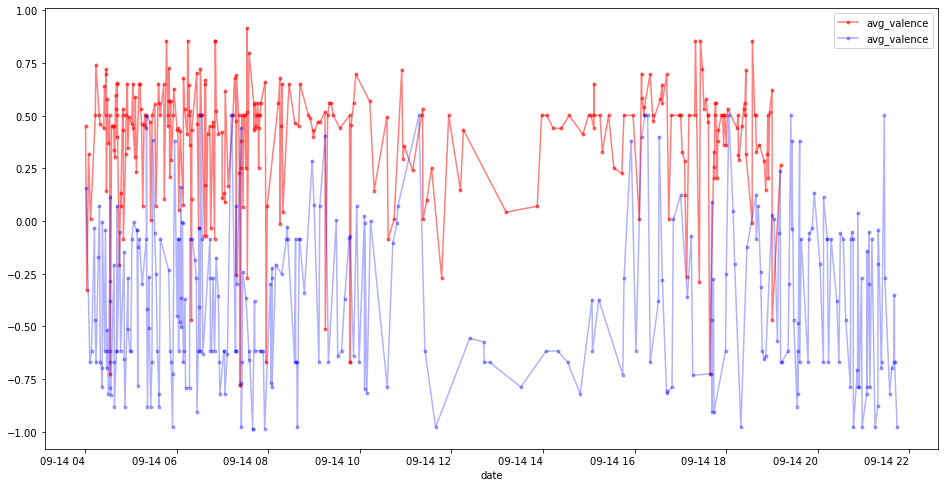

In [180]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

data_right.iloc[0:300].plot(x='date', y='avg_valence', c='r', ax=ax, alpha=0.5, rot=0, marker='.')
data_left.iloc[0:300].plot(x='date', y='avg_valence', c='b', ax=ax, alpha=0.3, rot=0, marker='.')

In [108]:
# TEST
#data_right[['val1', 'val2', 'val3', 'val4', 'val5', 'val6', 'val7', 'val8', 'val9', 'date']].groupby('date').mean()#.reset_index().groupby('date').mean()

### 1.2.3 Daily averages of valence

Unfortunately, the data does not seem to be very interesting. Lets aggregate the average daily valence of the two groups and see if there is any interesting behaviour

In [195]:
# To calculate the saily average, we have to index by date
data_right.set_index(['date'], inplace=True)
# Group by date and take the mean
daily_mean_val_right = data_right.groupby(pd.Grouper(freq='1D')).mean()


# To calculate the saily average, we have to index by date
data_left.set_index(['date'], inplace=True)
# Group by date and take the mean
daily_mean_val_left = data_left.groupby(pd.Grouper(freq='1D')).mean()

In [196]:
daily_mean_val_left.head()

,source,target,num_hyperlinks_in_tweet,val1,val2,val3,val4,val5,val6,val7,val8,val9,avg_valence
date,,,,,,,,,,,,,
2010-09-14,9486.160099,9327.231527,0.628079,-0.493425,-0.323913,-0.303414,-0.199150,-0.165131,-0.275741,-0.435633,-0.564266,NaN,-0.444484
2010-09-15,9894.420601,9464.895565,0.550787,-0.317986,-0.180560,-0.170753,-0.244860,0.008291,-0.301733,-0.210783,-0.482873,-0.031697,-0.277666
2010-09-16,9367.486538,9047.671154,0.634615,-0.427395,-0.249100,-0.279106,-0.288785,-0.032928,-0.244403,-0.176874,-0.401874,0.246481,-0.363774
2010-09-17,7329.519621,9138.603518,0.418133,-0.620701,-0.344133,-0.230534,-0.260814,-0.155748,-0.117509,0.138625,0.057687,0.855717,-0.582701
2010-09-18,9358.782178,9414.745050,0.542079,-0.476301,-0.316405,-0.220832,-0.257060,-0.119599,-0.157022,-0.026687,-0.200700,0.759684,-0.406328


In [197]:
#daily_mean_val_left.shape, daily_mean_val_right.shape

In [198]:
# Calculate mean political valence for left-leaning and right-leaning users
# We will plot this below
mvr = daily_mean_val_right['avg_valence'].mean()
mvl = daily_mean_val_left['avg_valence'].mean()

mvl, mvr

(-0.3989798875107243, 0.37430882595872506)

In [200]:
np.corrcoef(daily_mean_val_right['avg_valence'].values, daily_mean_val_left['avg_valence'].values)

array([[ 1.        , -0.13072553],
       [-0.13072553,  1.        ]])

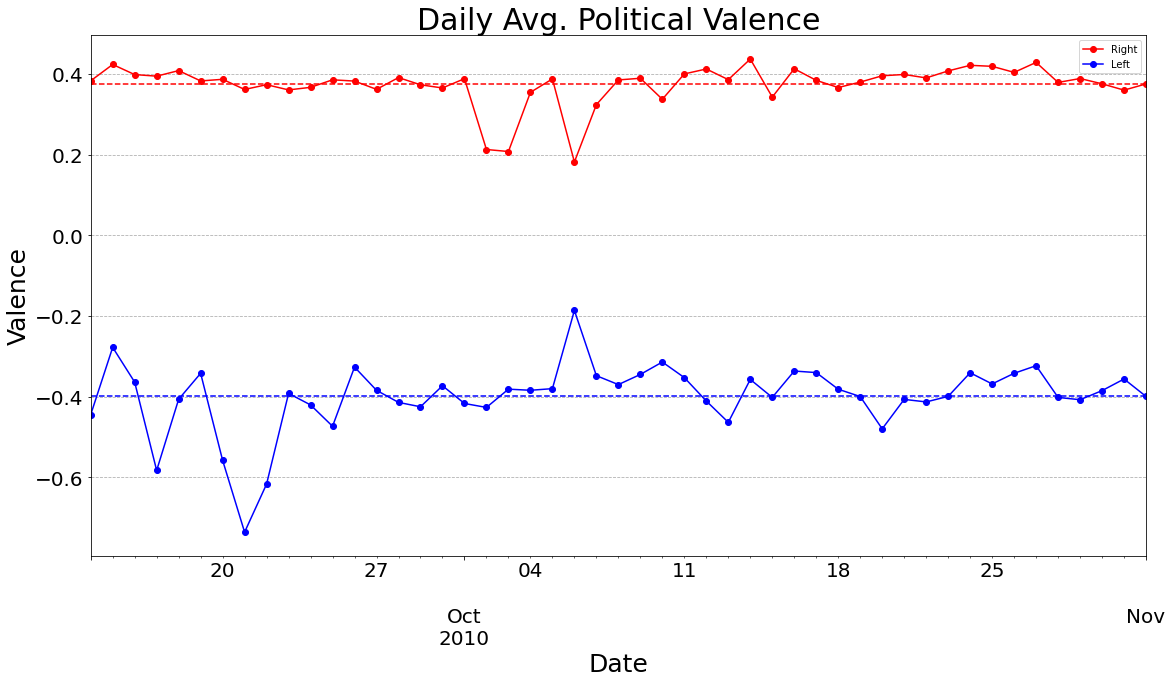

In [186]:
#test = np.log(1 + data_right[ht_vals].mean(axis=1))

# The data spans from 14/09/2010 to 1/11/2010
t0 = datetime.date(2010, 9, 14)
t1 = datetime.date(2010, 11, 1)

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

daily_mean_val_right.plot(y='avg_valence', c='r', ax=ax, marker='o', label='Right', fontsize=20)
daily_mean_val_left.plot(y='avg_valence', c='b', ax=ax, marker='o', label='Left')
plt.tight_layout()

ax.set_title('Daily Avg. Political Valence', fontsize=30)
ax.set_ylabel('Valence', fontsize=25)
ax.set_xlabel('Date', fontsize=25)
ax.hlines(mvl, t0, t1, linestyle='--', color='b')#, alpha=0.5)
ax.hlines(mvr, t0, t1, linestyle='--', color='r')#, alpha=0.5)
#ax.vlines(d, -0.65, 0.42, color='black', linestyle='--', alpha=0.5)
ax.grid(linestyle='--', axis='y')

We see that the daily averages are relatively stable. Lets see how the individual tweets correlate with each other